<a href="https://www.kaggle.com/code/klimyuriy/predict-people-personality-types?scriptVersionId=198138186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
import joblib
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-people-personality-types/data.csv


In [2]:
df=pd.read_csv('/kaggle/input/predict-people-personality-types/data.csv')
df

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP
...,...,...,...,...,...,...,...,...,...
128056,27.0,Male,0,5.11456,7.764336,5.72341,2.686904,Arts,ESTP
128057,19.0,Male,0,3.00078,2.525392,4.71081,3.657814,Unknown,INFP
128058,26.0,Female,1,8.16219,3.433857,2.45531,5.541144,Arts,ENFP
128059,24.0,Male,0,9.37782,5.077443,1.79598,6.762643,Unknown,ENFJ


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128061 entries, 0 to 128060
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 128061 non-null  float64
 1   Gender              128061 non-null  object 
 2   Education           128061 non-null  int64  
 3   Introversion Score  128061 non-null  float64
 4   Sensing Score       128061 non-null  float64
 5   Thinking Score      128061 non-null  float64
 6   Judging Score       128061 non-null  float64
 7   Interest            128061 non-null  object 
 8   Personality         128061 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 8.8+ MB


In [4]:
label_encoder = LabelEncoder()

df['Personality'] = label_encoder.fit_transform(df['Personality'])

mapping_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

df

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,1
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,5
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,1
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,11
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,1
...,...,...,...,...,...,...,...,...,...
128056,27.0,Male,0,5.11456,7.764336,5.72341,2.686904,Arts,7
128057,19.0,Male,0,3.00078,2.525392,4.71081,3.657814,Unknown,9
128058,26.0,Female,1,8.16219,3.433857,2.45531,5.541144,Arts,1
128059,24.0,Male,0,9.37782,5.077443,1.79598,6.762643,Unknown,0


In [5]:
df.describe()

,Age,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Personality
count,128061.000000,128061.000000,128061.000000,128061.000000,128061.000000,128061.000000,128061.000000
mean,26.349091,0.411156,4.996387,5.081893,4.988040,4.578293,5.532449
std,4.908022,0.492045,2.888636,1.183236,2.886018,1.391582,4.270469
min,18.000000,0.000000,0.000040,0.000000,0.000050,0.000000,0.000000
25%,23.000000,0.000000,2.490710,4.315659,2.488630,3.709353,1.000000
50%,25.000000,0.000000,4.993640,5.124169,4.984180,4.690653,3.000000
75%,29.000000,1.000000,7.500170,5.892288,7.492550,5.561229,9.000000
max,57.000000,1.000000,9.999990,9.788815,9.999970,9.840494,15.000000


In [6]:
X = df.drop(columns=['Personality'])
y = df['Personality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 76836 samples 	 60%
Test:  25613 samples 	 20%
Val:   25612 samples 	 20%


In [8]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value =-1))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns)
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['Age', 'Education', 'Introversion Score', 'Sensing Score',
       'Thinking Score', 'Judging Score'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 Index(['Gender', 'Interest'], dtype='object'))])

In [9]:
X_train = preprocessor.fit_transform(X_train)

X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [10]:
X_train

,num__Age,num__Education,num__Introversion Score,num__Sensing Score,num__Thinking Score,num__Judging Score,cat__Gender,cat__Interest
66842,29.0,0.0,8.77941,5.750681,9.65169,2.851037,1.0,3.0
84742,30.0,1.0,8.77947,2.826224,2.71665,3.914451,1.0,0.0
31273,23.0,1.0,6.59143,5.405704,2.05294,4.833644,1.0,4.0
75774,25.0,1.0,6.67959,3.408619,2.01919,5.770528,0.0,0.0
44087,19.0,0.0,5.79326,4.739469,1.02278,4.147018,1.0,4.0
...,...,...,...,...,...,...,...,...
92267,20.0,1.0,6.02898,5.366851,4.38517,3.913097,1.0,3.0
89232,20.0,0.0,1.63016,4.826213,3.64460,4.165899,1.0,0.0
115060,30.0,1.0,6.00244,4.614609,0.25074,5.612953,1.0,4.0
3752,25.0,0.0,1.44747,5.680062,0.23950,5.371691,1.0,0.0


In [11]:
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss', 'rf']),
        'n_estimators': trial.suggest_int('n_estimators', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 10.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 15, 255),
        'boost_from_average': True,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1e-3, 10.0),
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),
        'metric': 'rmse',
        'verbosity': -1,
        'force_col_wise': trial.suggest_categorical('force_col_wise', [True, False]),
        'max_cat_threshold': trial.suggest_int('max_cat_threshold', 1, 128),
        'cat_l2': trial.suggest_float('cat_l2', 1e-3, 10.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1e-3, 10.0),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 128),
        'top_rate': trial.suggest_float('top_rate', 0.0, 1.0),
        'other_rate': trial.suggest_float('other_rate', 0.0, 1.0 - trial.suggest_float('top_rate', 0.0, 1.0)),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 1, 100),
        'max_cat_trees': trial.suggest_int('max_cat_trees', 1, 128),
        'path_smooth': trial.suggest_float('path_smooth', 0.0, 1.0),
        'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.0, 1.0),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.0, 2.0),
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(stopping_rounds=trial.suggest_int('early_stopping_round', 10, 100), verbose=False)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping_callback]
    )

    y_pred = model.predict(X_val)
    r2 = metrics.r2_score(y_val, y_pred)
    mae = metrics.mean_absolute_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5

    return r2, mae, rmse

In [12]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=1000)

/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:325:

In [13]:
len(study.best_trials)

11

In [14]:
print(f"Best metric: {study.best_trials}")

Best metric: [FrozenTrial(number=488, state=TrialState.COMPLETE, values=[0.8238077016130316, 0.8789773721795796, 1.7985924713123438], datetime_start=datetime.datetime(2024, 9, 24, 21, 35, 31, 831255), datetime_complete=datetime.datetime(2024, 9, 24, 21, 35, 33, 808200), params={'boosting_type': 'gbdt', 'n_estimators': 139, 'learning_rate': 0.06724674940462841, 'num_leaves': 101, 'max_depth': 12, 'min_data_in_leaf': 114, 'min_sum_hessian_in_leaf': 0.14090797370562974, 'feature_fraction': 0.970405451516433, 'lambda_l1': 7.432634529612138e-06, 'lambda_l2': 2.089120236036317e-08, 'min_gain_to_split': 0.304113908327864, 'max_bin': 238, 'scale_pos_weight': 6.554454261631292, 'is_unbalance': False, 'force_col_wise': True, 'max_cat_threshold': 23, 'cat_l2': 9.835356415721696, 'cat_smooth': 1.004615836275969, 'max_cat_to_onehot': 14, 'top_rate': 0.7050683712105816, 'other_rate': 0.11851691284660046, 'min_data_per_group': 56, 'max_cat_trees': 29, 'path_smooth': 0.792957769682178, 'feature_fracti

In [15]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.823808,0.878977,1.798592
1,0.822229,0.876946,1.806633
2,0.822043,0.873741,1.807578
3,0.821882,0.873658,1.808396
4,0.820683,0.870824,1.814470
5,0.820683,0.870824,1.814470
6,0.821882,0.873658,1.808396
7,0.822052,0.873855,1.807530
8,0.825228,0.880750,1.791331
9,0.825685,0.883863,1.788986


In [16]:
best_params = study.best_trials[0].params
best_params

{'boosting_type': 'gbdt',
 'n_estimators': 139,
 'learning_rate': 0.06724674940462841,
 'num_leaves': 101,
 'max_depth': 12,
 'min_data_in_leaf': 114,
 'min_sum_hessian_in_leaf': 0.14090797370562974,
 'feature_fraction': 0.970405451516433,
 'lambda_l1': 7.432634529612138e-06,
 'lambda_l2': 2.089120236036317e-08,
 'min_gain_to_split': 0.304113908327864,
 'max_bin': 238,
 'scale_pos_weight': 6.554454261631292,
 'is_unbalance': False,
 'force_col_wise': True,
 'max_cat_threshold': 23,
 'cat_l2': 9.835356415721696,
 'cat_smooth': 1.004615836275969,
 'max_cat_to_onehot': 14,
 'top_rate': 0.7050683712105816,
 'other_rate': 0.11851691284660046,
 'min_data_per_group': 56,
 'max_cat_trees': 29,
 'path_smooth': 0.792957769682178,
 'feature_fraction_bynode': 0.7720195714370566,
 'tweedie_variance_power': 1.8664466550374776,
 'early_stopping_round': 11}

In [17]:
model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 1000,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(cat_l2=9.835356415721696, cat_smooth=1.004615836275969,
              early_stopping_round=11, feature_fraction=0.970405451516433,
              feature_fraction_bynode=0.7720195714370566, force_col_wise=True,
              is_unbalance=False, lambda_l1=7.432634529612138e-06,
              lambda_l2=2.089120236036317e-08,
              learning_rate=0.06724674940462841, max_bin=238,
              max_cat_threshold=23, max_cat_to...
              max_depth=12, min_data_in_leaf=114, min_data_per_group=56,
              min_gain_to_split=0.304113908327864,
              min_sum_hessian_in_leaf=0.14090797370562974, n_estimator=1000,
              n_estimators=139, num_leaves=101, other_rate=0.11851691284660046,
              path_smooth=0.792957769682178, scale_pos_weight=6.554454261631292,
              top_rate=0.7050683712105816,
              tweedie_variance_power=1.8664466550374776, verbose=-1)

In [18]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [19]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,0.82,0.87
RMSE,1.68,1.79
R2,0.85,0.82


In [20]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

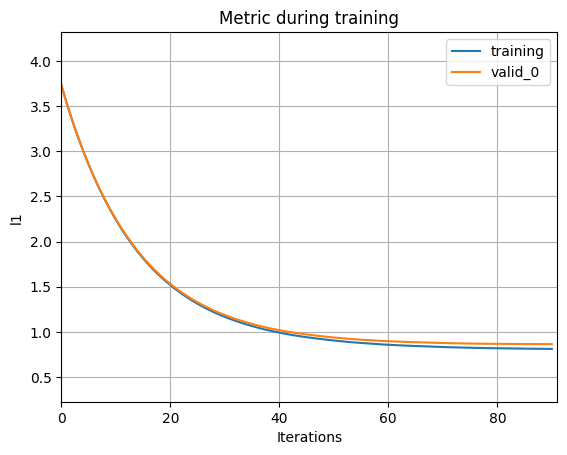

In [21]:
lgb.plot_metric(model,
                metric='l1')

In [22]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Age', 'Education', 'Introversion Score', 'Sensing Score',
       'Thinking Score', 'Judging Score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown...
                               min_data_in_leaf=114, min_data_per_group=56,
                               min_gain_to_split=0.304113908327864,
                               min_sum_hessian_in_leaf=0.14090797370562974,
                               n_estimator=1000, n_estimators=139,
                               num_leaves=101, other_rate=0.11851691284660046,
                               path_smooth=0.792957769682178,
                               scale_pos_weight=6.554454261631292,
                               top_rate=0.7050683712105816,
                               tweedie_variance_power=1.8664466550374776,
                               verbose=-1))])

In [23]:
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']

In [24]:
load_model = joblib.load('my_model.pkl')
load_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['Age', 'Education', 'Introversion Score', 'Sensing Score',
       'Thinking Score', 'Judging Score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown...
                               min_data_in_leaf=114, min_data_per_group=56,
                               min_gain_to_split=0.304113908327864,
                               min_sum_hessian_in_leaf=0.14090797370562974,
                               n_estimator=1000, n_estimators=139,
                               num_leaves=101, other_rate=0.11851691284660046,
                               path_smooth=0.792957769682178,
                               scale_pos_weight=6.554454261631292,
                               top_rate=0.7050683712105816,
                               tweedie_variance_power=1.8664466550374776,
                               verbose=-1))])